# 1. Introdução
O notebook abaixo apresenta e implementa o spot-checking de modelos preditivos supervisionados, desenvolvido para primeiro trabalho da disciplina Aprendizado de Máquina da Universidade Federal do Rio Grande do Sul (2024/2).

Neste trabalho, buscamos analisar a relação de diversos fatores, como gênero e notas do primeiro semestre, com a taxa de desistência de alunos. No modelo abaixo usamos o dataset carregado nesse notebook, analisamos quais os fatores que de fato influenciam na desistência dos alunos e possibilitamos que inputs personalizados sejam adicionados ao modelo para que seja calculado a probabilidade de um aluno desistir do curso.


## Setup

In [1]:
!pip install pandas plotly matplotlib seaborn scikit-learn xgboost optuna hyperopt setuptools nbformat

In [2]:
# Módulo para leitura e manipulação dos dados
import pandas as pd

# Módulo para manipulação de arrays e matrizes
import numpy as np

# Módulos para visualização de dados e plotagem de gráficos
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns

# Módulos específicos da sklearn
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import accuracy_score,f1_score,precision_score,recall_score, roc_auc_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn import svm
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import VotingClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.feature_selection import SelectKBest, mutual_info_classif

# Biblioteca com algoritmos específicos de machine learning
from xgboost import XGBClassifier

# Módulo para balanceamento de classes
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

import optuna
from optuna.visualization import plot_optimization_history, plot_slice, plot_contour, plot_parallel_coordinate, plot_param_importances
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials

c:\Users\Matheus\source\repos\ipp-student-dropout\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# 1. Carregamento dos dados

Dataset pré-processado no notebook [t1-spot-checking.ipynb](./t1-spot-checking.ipynb)

---
Dataset obtido em https://www.kaggle.com/datasets/thedevastator/higher-education-predictors-of-student-retention/data

Original: https://zenodo.org/records/5777340#.Y7FJotJBwUE

In [3]:
data = pd.read_csv("../data/clean-dataset.csv")

In [4]:
# Separa atributos preditivos e atributo alvo
X = data.drop('Target', axis=1)
y = data['Target']

In [5]:
# Algoritmos selecionados para treinamento
dtree = DecisionTreeClassifier(random_state=0)
dtree2 = DecisionTreeClassifier(random_state=0, max_depth=10)
rfc_gini = RandomForestClassifier(random_state=2)
rfc_entropy = RandomForestClassifier(random_state=2, criterion='entropy')
lr = LogisticRegression(random_state=42)
knn_3 = KNeighborsClassifier(n_neighbors=3)
knn_5 = KNeighborsClassifier(n_neighbors=5)
abc = AdaBoostClassifier(n_estimators=50,learning_rate=1, random_state=0, algorithm='SAMME')
svmachine = svm.SVC(kernel='linear',probability=True)

algo_dict = {'Decision Tree': dtree, 'Decision Tree Max depth 5': dtree2, 'Random Forest gini': rfc_gini, 'Random Forest entropy': rfc_entropy, 'Logistic Regression': lr, '3-Nearest Neighbors': knn_3, '5-Nearest Neighbors': knn_5, 'AdaBoost': abc, 'SVM': svmachine}

In [6]:
# Referências
# https://machinelearningmastery.com/spot-check-machine-learning-algorithms-in-python/
# https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html
def make_pipeline(model):
    steps = list()

    steps.append(('Feature Selection', SelectKBest(k=10, score_func=mutual_info_classif)))
    steps.append(('Normalização', StandardScaler()))
    steps.append(('Balanceamento da classe minoritária', SMOTE(sampling_strategy='minority')))
    steps.append(('Modelo', model))

    # Cria a pipeline
    pipe = Pipeline(steps=steps)

    return pipe

In [7]:
# def define_grid_search_params(model_name):
#     if model_name == 'Random Forest gini' or model_name == 'Random Forest entropy':
#         return {
#             'Modelo__n_estimators': [50, 100, 150],
#             'Modelo__max_depth': [10, 20, 30]
#         }
#     elif model_name == 'Decision Tree' or model_name == 'Decision Tree Max depth 5':
#         return {
#             'Modelo__max_depth': [5, 10, 20, 30]
#         }
#     elif model_name == 'Logistic Regression':
#         return {
#             'Modelo__C': [0.01, 0.1, 1, 10, 100]
#         }
#     elif model_name == '3-Nearest Neighbors' or model_name == '5-Nearest Neighbors':
#         return {
#             'Modelo__n_neighbors': [3, 5, 7, 10]
#         }
#     elif model_name == 'AdaBoost':
#         return {
#             'Modelo__n_estimators': [50, 100, 150],
#             'Modelo__learning_rate': [0.01, 0.1, 1]
#         }
#     elif model_name == 'SVM':
#         return {
#             'Modelo__C': [0.01, 0.1, 1, 10],
#             'Modelo__kernel': ['linear', 'rbf']
#         }
#     else:
#         raise ValueError(f"Não foi definido parâmetro para o modelo: {model_name}")

In [8]:
# def nested_cv_with_gridsearch(X, y, models, outer_folds=5, inner_folds=3, metric='f1'):
#     outer_cv = StratifiedKFold(n_splits=outer_folds, shuffle=True, random_state=42)
#     results = []

#     for model_name, model in models.items():
#         param_grid = define_grid_search_params(model_name)

#         for train_idx, test_idx in outer_cv.split(X, y):
#             X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
#             y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

#             pipeline = make_pipeline(model)

#             grid_search = GridSearchCV(
#                 estimator=pipeline,
#                 param_grid=param_grid,
#                 cv=StratifiedKFold(n_splits=inner_folds, shuffle=True, random_state=42),
#                 scoring=metric,
#                 n_jobs=-1
#             )

#             grid_search.fit(X_train, y_train)

#             best_pipeline = grid_search.best_estimator_
#             y_pred = best_pipeline.predict(X_test)

#             metrics = {
#                 'Model': model_name,
#                 'F1 Score': f1_score(y_test, y_pred),
#                 'Precision': precision_score(y_test, y_pred),
#                 'Recall': recall_score(y_test, y_pred),
#                 'ROC AUC': roc_auc_score(y_test, best_pipeline.predict_proba(X_test)[:, 1])
#             }
#             results.append(metrics)

#     return pd.DataFrame(results)

In [9]:
# results_df = nested_cv_with_gridsearch(X, y, algo_dict, outer_folds=5, inner_folds=3, metric='f1')
# display(results_df)

In [10]:
# def define_hyperopt_space(model_name):
#     if model_name == 'Random Forest gini' or model_name == 'Random Forest entropy':
#         return {
#             'n_estimators': hp.quniform('n_estimators', 50, 300, 10),
#             'max_depth': hp.quniform('max_depth', 5, 50, 1),
#         }
#     elif model_name == 'Decision Tree' or model_name == 'Decision Tree Max depth 5':
#         return {
#             'max_depth': hp.quniform('max_depth', 5, 50, 1),
#         }
#     elif model_name == 'Logistic Regression':
#         return {
#             'C': hp.loguniform('C', np.log(1e-4), np.log(1e2)),
#         }
#     elif model_name == '3-Nearest Neighbors' or model_name == '5-Nearest Neighbors':
#         return {
#             'n_neighbors': hp.quniform('n_neighbors', 3, 20, 1),
#         }
#     elif model_name == 'AdaBoost':
#         return {
#             'n_estimators': hp.quniform('n_estimators', 50, 300, 10),
#             'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(2)),
#         }
#     elif model_name == 'SVM':
#         return {
#             'C': hp.loguniform('C', np.log(1e-4), np.log(1e2)),
#             'kernel': hp.choice('kernel', ['linear', 'rbf']),
#         }

In [11]:
# def nested_cv_with_hyperopt(X, y, models, outer_folds=5, inner_folds=3, metric='f1'):
#     outer_cv = StratifiedKFold(n_splits=outer_folds, shuffle=True, random_state=42)
#     results = []

#     for model_name, model in models.items():

#         # Define objective function for Hyperopt
#         def objective(params):
#             # If SVM, map the kernel index to string for correct cross-validation
#             if 'kernel' in params and model_name == 'SVM':
#                 kernel_mapping = ['linear', 'rbf']
#                 if isinstance(params['kernel'], int):
#                     params['kernel'] = kernel_mapping[params['kernel']]

#             pipeline = make_pipeline(model)

#             # Convert integer-like floats to int
#             final_params = {}
#             for k, v in params.items():
#                 if isinstance(v, float) and v.is_integer():
#                     v = int(v)  # Convert to int if it is a whole number float
#                 final_params[f'Modelo__{k}'] = v

#             pipeline.set_params(**final_params)

#             inner_cv = StratifiedKFold(n_splits=inner_folds, shuffle=True, random_state=42)
#             scores = cross_val_score(pipeline, X_train, y_train, cv=inner_cv, scoring=metric, n_jobs=-1)
#             return {'loss': -np.mean(scores), 'status': STATUS_OK}

#         # Outer loop
#         for train_idx, test_idx in outer_cv.split(X, y):
#             X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
#             y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

#             search_space = define_hyperopt_space(model_name)
#             trials = Trials()

#             best_params = fmin(
#                 fn=objective,
#                 space=search_space,
#                 algo=tpe.suggest,
#                 max_evals=20,
#                 trials=trials,
#             )

#             # Map SVM kernel back if needed
#             if model_name == 'SVM' and 'kernel' in best_params:
#                 kernel_mapping = ['linear', 'rbf']
#                 best_params['kernel'] = kernel_mapping[best_params['kernel']]

#             # Convert parameters and retrain pipeline
#             final_params = {}
#             for k, v in best_params.items():
#                 if isinstance(v, float) and v.is_integer():
#                     v = int(v)
#                 final_params[f'Modelo__{k}'] = v

#             # Train the pipeline with the best parameters
#             pipeline = make_pipeline(model)
#             pipeline.set_params(**final_params)
#             pipeline.fit(X_train, y_train)

#             # Evaluate on the test set
#             y_pred = pipeline.predict(X_test)
#             metrics = {
#                 'Model': model_name,
#                 'F1 Score': f1_score(y_test, y_pred),
#                 'Precision': precision_score(y_test, y_pred),
#                 'Recall': recall_score(y_test, y_pred),
#                 'ROC AUC': roc_auc_score(y_test, pipeline.predict_proba(X_test)[:, 1])
#             }
#             results.append(metrics)

#     return pd.DataFrame(results)

In [12]:
# results_df = nested_cv_with_hyperopt(X, y, algo_dict, outer_folds=5, inner_folds=3, metric='f1')
# display(results_df)

In [13]:
# def define_optuna_space(model_name, trial):
#     if model_name == 'Random Forest gini' or model_name == 'Random Forest entropy':
#         return {
#             'Modelo__n_estimators': trial.suggest_int('n_estimators', 50, 300),
#             'Modelo__max_depth': trial.suggest_int('max_depth', 5, 50)
#         }
#     elif model_name == 'Decision Tree' or model_name == 'Decision Tree Max depth 5':
#         return {
#             'Modelo__max_depth': trial.suggest_int('max_depth', 5, 50)
#         }
#     elif model_name == 'Logistic Regression':
#         return {
#             'Modelo__C': trial.suggest_float('C', 1e-3, 1e3, log=True)
#         }
#     elif model_name == '3-Nearest Neighbors' or model_name == '5-Nearest Neighbors':
#         return {
#             'Modelo__n_neighbors': trial.suggest_int('n_neighbors', 3, 20)
#         }
#     elif model_name == 'AdaBoost':
#         return {
#             'Modelo__n_estimators': trial.suggest_int('n_estimators', 50, 500),
#             'Modelo__learning_rate': trial.suggest_float('learning_rate', 0.01, 2, log=True)
#         }
#     elif model_name == 'SVM':
#         return {
#             'Modelo__C': trial.suggest_float('C', 1e-4, 1e2, log=True),
#             'Modelo__kernel': trial.suggest_categorical('kernel', ['linear', 'rbf'])
#         }

In [14]:
def define_optuna_space(model_name, trial):
    
    # Define o espaço de busca de hiperparâmetros para cada tipo de modelo
    if model_name == 'Logistic Regression':

        # Caso a gente queira fazer uma avaliação mais simples:
        # # Para regressão logística, ajusta o parâmetro de regularização C
        # return {
        #     'Modelo__C': trial.suggest_float('C', 1e-3, 1e3, log=True)
        # }

        # Senão, com mais hiperparâmetros:
        solver_penalty_str = trial.suggest_categorical(
            'solver_penalty',
            ['liblinear_l1', 'liblinear_l2', 'lbfgs_l2']
        )

        # Quebra as strings de maneira a ter o solver e a penalidade certa
        solver, penalty = solver_penalty_str.split('_')

        return {
            'Modelo__C': trial.suggest_float('C', 1e-3, 1e3, log=True),
            'Modelo__solver': solver,
            'Modelo__penalty': penalty
        }

    elif model_name == 'AdaBoost':
        # Para AdaBoost, ajusta o número de estimadores e a taxa de aprendizado
        return {
            'Modelo__n_estimators': trial.suggest_int('n_estimators', 50, 500),
            'Modelo__learning_rate': trial.suggest_float('learning_rate', 0.01, 2, log=True)
        }
    elif model_name == 'SVM':
        # Para SVM, ajusta o parâmetro C e o tipo de kernel
        return {
            'Modelo__C': trial.suggest_float('C', 1e-4, 1e2, log=True),
            'Modelo__kernel': trial.suggest_categorical('kernel', ['linear', 'rbf', 'sigmoid'])
        }
    else:
        # Se nenhum hiperparâmetro estiver definido no modelo, retorna um dicionário vazio
        return {}

In [15]:
def objective_function(trial, model_name, model, X_train, y_train, inner_folds, metric):
    # Define o espaço de busca dos hiperparâmetros
    params = define_optuna_space(model_name, trial)

    # Cria o pipeline com seleção de atributos, normalização, balanceamento e o modelo
    pipeline = make_pipeline(model)

    # Ajusta o pipeline com os hiperparâmetros sugeridos pelo trial do optuna
    pipeline.set_params(**params)

    # Define o k-fold interno para validação cruzada
    inner_cv = StratifiedKFold(n_splits=inner_folds, shuffle=True, random_state=42)

    # Calcula a métrica de avaliação média (por ex. F1) através de validação cruzada
    score = cross_val_score(pipeline, X_train, y_train, cv=inner_cv, scoring=metric, n_jobs=-1).mean()
    return score


In [16]:
# Executa o estudo do Optuna para um único fold externo e retorna o melhor estudo
def run_optuna_study_for_fold(model_name, model, X_train, y_train, inner_folds, metric, n_trials=20):

    # Função objetivo que o Optuna irá otimizar
    def objective(trial):
        return objective_function(trial, model_name, model, X_train, y_train, inner_folds, metric)

    # Cria o estudo do Optuna com objetivo de maximizar a métrica
    study = optuna.create_study(direction="maximize")

    # Executa o estudo com número definido de tentativas (n_trials)
    study.optimize(objective, n_trials=n_trials)
    return study

In [17]:
# Avalia o modelo com os melhores parâmetros encontrados no conjunto de teste.
def evaluate_best_params(model, best_params, X_train, y_train, X_test, y_test):
    pipeline = make_pipeline(model)
    pipeline.set_params(**best_params) # Ajusta o pipeline com os melhores parâmetros
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)

    return {
        'F1 Score': f1_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'ROC AUC': roc_auc_score(y_test, pipeline.predict_proba(X_test)[:, 1])
    }

In [18]:
def nested_cv_with_optuna(X, y, models, outer_folds, inner_folds, metric):

    # Define o k-fold externo para a nested cv
    outer_cv = StratifiedKFold(n_splits=outer_folds, shuffle=True, random_state=42)
    results = []
    best_study_per_model = {}
    best_params_per_model = {}
    best_f1_per_model = {}
    all_fold_params_per_model = {}

    # Loop pelos modelos que serão ajustados
    for model_name, model in models.items():
        # Vamos armazenar o melhor estudo e parâmetros por conveniência, 
        # mas não iremos basear a escolha dos parâmetros no conjunto de teste.
        studies = []
        fold_params = []
        fold_test_metrics = []

        # Loop do k-fold externo
        for train_idx, test_idx in outer_cv.split(X, y):
            X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
            y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

            # Executa o estudo do Optuna para o fold atual
            study = run_optuna_study_for_fold(model_name, model, X_train, y_train, inner_folds, metric, n_trials=100)
            studies.append(study)  # Append the study to the list

            # Obtém os melhores parâmetros do estudo
            fold_best_params = {f'Modelo__{key}': value for key, value in study.best_params.items()}

            # Retira os pares de strings solver_penalty, caso presentes
            if 'Modelo__solver_penalty' in fold_best_params:
                del fold_best_params['Modelo__solver_penalty']

            # Avalia no conjunto de teste com os melhores parâmetros
            metrics = evaluate_best_params(model, fold_best_params, X_train, y_train, X_test, y_test)
            metrics['Model'] = model_name
            results.append(metrics)

            fold_params.append(fold_best_params)
            fold_test_metrics.append(metrics['F1 Score'])

        # Aqui, best_study_per_model, best_params_per_model, e best_f1_per_model não usam o conjunto de teste para escolha,
        # mas iremos apenas reportar os melhores resultados encontrados internamente.
        # Como cada fold externo produz seu próprio conjunto de parâmetros, 
        # não há um único "melhor" conjunto global, pois cada outer fold é independente.
        # Podemos, por exemplo, escolher o primeiro estudo ou o estudo com melhor média interna.
        best_study_per_model[model_name] = studies[0]
        best_params_per_model[model_name] = fold_params[0]  # por exemplo, o primeiro fold
        best_f1_per_model[model_name] = sum(fold_test_metrics) / len(fold_test_metrics)

        all_fold_params_per_model[model_name] = fold_params

    # Retorna os resultados consolidados, o melhor estudo, os melhores parâmetros e a melhor pontuação F1 por modelo
    return pd.DataFrame(results), best_study_per_model, best_params_per_model, best_f1_per_model, all_fold_params_per_model

In [19]:
optuna_algo_dict = {
    'Logistic Regression': algo_dict['Logistic Regression'],
    'AdaBoost': algo_dict['AdaBoost'],
    'SVM': algo_dict['SVM']
}

# Executa a validação cruzada aninhada com otimização de hiperparâmetros via Optuna
results_df, best_study_per_model, best_params_per_model, best_f1_per_model, all_fold_params_per_model = nested_cv_with_optuna(X, y, optuna_algo_dict, outer_folds=10, inner_folds=5, metric='f1')
display(results_df)

[I 2024-12-11 19:09:25,788] A new study created in memory with name: no-name-eb299460-a59b-4b8c-84c1-0088506cc466
[I 2024-12-11 19:09:27,252] Trial 0 finished with value: 0.7433150242419673 and parameters: {'solver_penalty': 'liblinear_l1', 'C': 7.031327657554267}. Best is trial 0 with value: 0.7433150242419673.
[I 2024-12-11 19:09:28,158] Trial 1 finished with value: 0.7383857705304026 and parameters: {'solver_penalty': 'liblinear_l2', 'C': 80.55077288104053}. Best is trial 0 with value: 0.7433150242419673.
[I 2024-12-11 19:09:29,094] Trial 2 finished with value: 0.7440299602164775 and parameters: {'solver_penalty': 'liblinear_l2', 'C': 499.8502958400569}. Best is trial 2 with value: 0.7440299602164775.
[I 2024-12-11 19:09:30,021] Trial 3 finished with value: 0.7426241384667615 and parameters: {'solver_penalty': 'lbfgs_l2', 'C': 0.027586619127288655}. Best is trial 2 with value: 0.7440299602164775.
[I 2024-12-11 19:09:31,009] Trial 4 finished with value: 0.7465380054522972 and paramet

,F1 Score,Precision,Recall,ROC AUC,Model
0,0.712230,0.733333,0.692308,0.870058,Logistic Regression
1,0.717241,0.702703,0.732394,0.871918,Logistic Regression
2,0.761905,0.736842,0.788732,0.885183,Logistic Regression
3,0.731343,0.777778,0.690141,0.872935,Logistic Regression
4,0.759124,0.787879,0.732394,0.890786,Logistic Regression
5,0.748201,0.764706,0.732394,0.893192,Logistic Regression
6,0.741259,0.736111,0.746479,0.885904,Logistic Regression
7,0.730496,0.735714,0.725352,0.872746,Logistic Regression
8,0.756184,0.758865,0.753521,0.889073,Logistic Regression
9,0.728625,0.771654,0.690141,0.863592,Logistic Regression


In [20]:
for model_name in best_params_per_model:
    print(f"Best parameters for {model_name}: {best_params_per_model[model_name]}")

Best parameters for Logistic Regression: {'Modelo__C': 0.06896045474733162}
Best parameters for AdaBoost: {'Modelo__n_estimators': 354, 'Modelo__learning_rate': 0.9617040407042302}
Best parameters for SVM: {'Modelo__C': 0.0035855006896749995, 'Modelo__kernel': 'sigmoid'}


In [21]:
for model_name, fold_params_list in all_fold_params_per_model.items():
    for fold_idx, fold_params in enumerate(fold_params_list, start=1):
        print(f"Parameters for {model_name}, Fold {fold_idx}: {fold_params}")

Parameters for Logistic Regression, Fold 1: {'Modelo__C': 0.06896045474733162}
Parameters for Logistic Regression, Fold 2: {'Modelo__C': 0.012049646244167104}
Parameters for Logistic Regression, Fold 3: {'Modelo__C': 0.07824841659081987}
Parameters for Logistic Regression, Fold 4: {'Modelo__C': 0.03289139338627584}
Parameters for Logistic Regression, Fold 5: {'Modelo__C': 0.03221175899382644}
Parameters for Logistic Regression, Fold 6: {'Modelo__C': 0.0018218209813739088}
Parameters for Logistic Regression, Fold 7: {'Modelo__C': 1.1494167933282426}
Parameters for Logistic Regression, Fold 8: {'Modelo__C': 0.005378150903026494}
Parameters for Logistic Regression, Fold 9: {'Modelo__C': 0.015525976294445767}
Parameters for Logistic Regression, Fold 10: {'Modelo__C': 0.01148556368532946}
Parameters for AdaBoost, Fold 1: {'Modelo__n_estimators': 354, 'Modelo__learning_rate': 0.9617040407042302}
Parameters for AdaBoost, Fold 2: {'Modelo__n_estimators': 178, 'Modelo__learning_rate': 1.2373658

In [22]:
best_study = best_study_per_model[model_name]
print(best_study.best_params)  # Dictionary of best hyperparameters

{'C': 0.0035855006896749995, 'kernel': 'sigmoid'}


In [23]:
# Exibe os melhores resultados e parâmetros para cada modelo
for model_name in best_study_per_model:
    print(f"Best F1 for {model_name}: {best_f1_per_model[model_name]}")
    print(f"Best Parameters for {model_name}: {best_params_per_model[model_name]}")

    print(f"Plots for model: {model_name}")

    study = best_study_per_model[model_name]
    fig_opt_history = plot_optimization_history(study)
    fig_opt_history.show()

    fig_slice = plot_slice(study)
    fig_slice.show()

    fig_parallel = plot_parallel_coordinate(study)
    fig_parallel.show()

    fig_contour = plot_contour(study)
    fig_contour.show()

    fig_param_importances = plot_param_importances(study)
    fig_param_importances.show()

Best F1 for Logistic Regression: 0.7386608643123171
Best Parameters for Logistic Regression: {'Modelo__C': 0.06896045474733162}
Plots for model: Logistic Regression


Best F1 for AdaBoost: 0.7509018421930426
Best Parameters for AdaBoost: {'Modelo__n_estimators': 354, 'Modelo__learning_rate': 0.9617040407042302}
Plots for model: AdaBoost


Best F1 for SVM: 0.7307128445208382
Best Parameters for SVM: {'Modelo__C': 0.0035855006896749995, 'Modelo__kernel': 'sigmoid'}
Plots for model: SVM


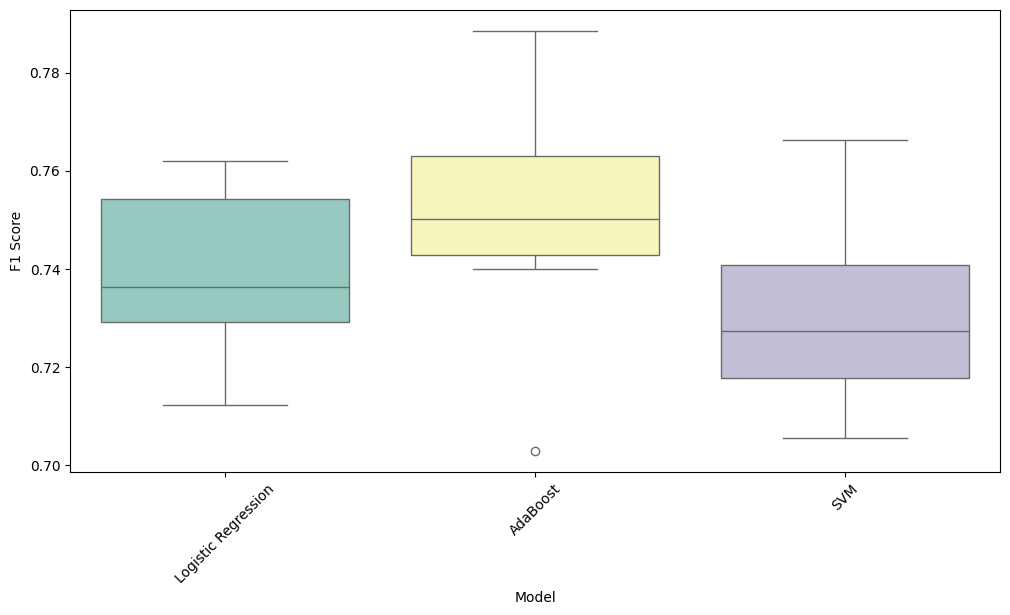

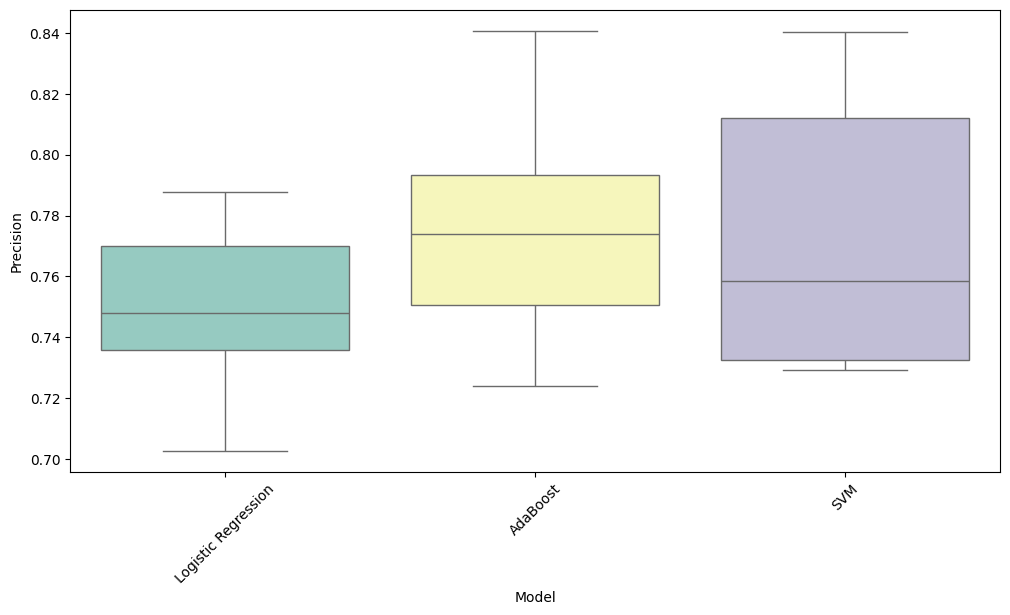

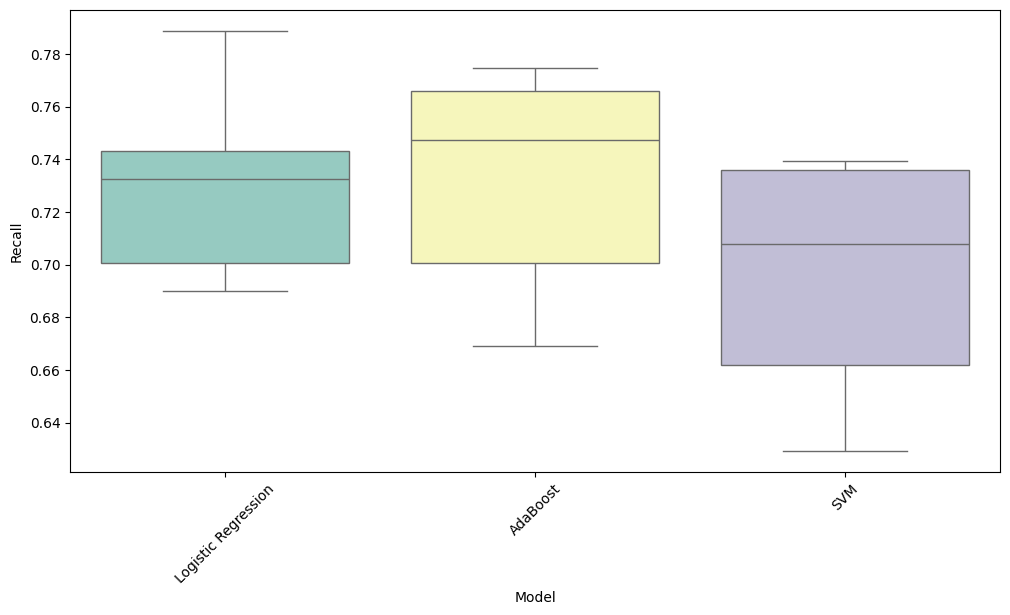

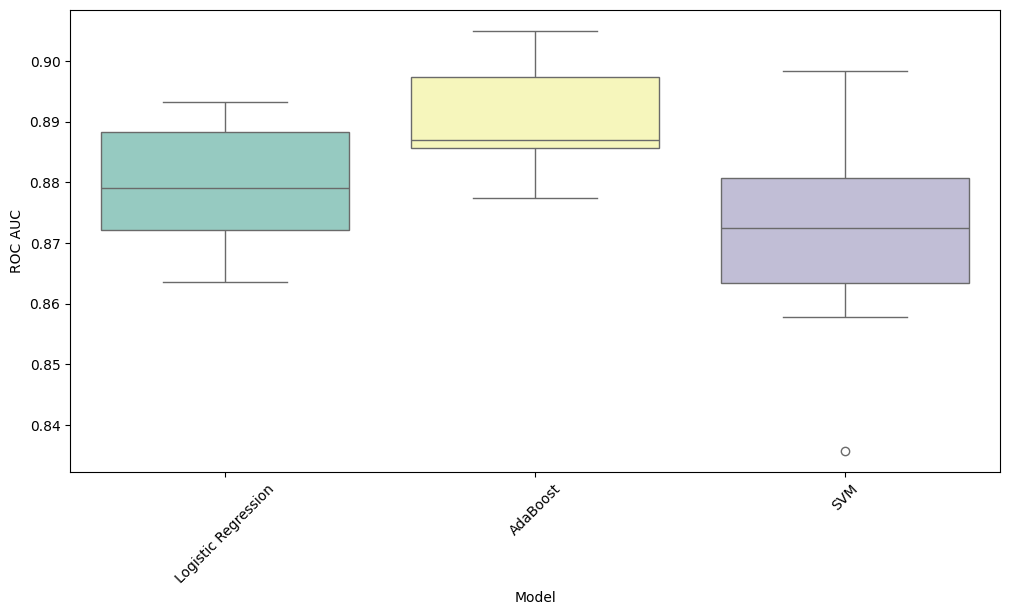

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns

# Boxplot de F1
plt.figure(figsize=(12, 6))
sns.boxplot(data=results_df, x='Model', y='F1 Score', hue='Model', palette='Set3')
plt.xticks(rotation=45)
plt.show()

# Boxplot da precisão
plt.figure(figsize=(12, 6))
sns.boxplot(data=results_df, x='Model', y='Precision', hue='Model', palette='Set3')
plt.xticks(rotation=45)
plt.show()

# Boxplot do recall
plt.figure(figsize=(12, 6))
sns.boxplot(data=results_df, x='Model', y='Recall', hue='Model', palette='Set3')
plt.xticks(rotation=45)
plt.show()

# Boxplot da ROC AUC
plt.figure(figsize=(12, 6))
sns.boxplot(data=results_df, x='Model', y='ROC AUC', hue='Model', palette='Set3')
plt.xticks(rotation=45)
plt.show()


In [25]:
# Load the dataset
data = pd.read_csv("../data/clean-dataset.csv")

X = data.drop('Target', axis=1)
y = data['Target']

# Split into training and test sets 
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.3, 
                                                    random_state=42, 
                                                    stratify=y)

# Define a function to create the pipeline
def make_pipeline():
    steps = [
        ('Feature Selection', SelectKBest(k=10, score_func=mutual_info_classif)),
        ('Normalização', StandardScaler()),
        ('Balanceamento', SMOTE(sampling_strategy='minority', random_state=42)),
        ('Modelo', AdaBoostClassifier(random_state=0, algorithm='SAMME'))
    ]
    pipe = Pipeline(steps=steps)
    return pipe

# Define the objective function for Optuna
def objective(trial):
    # Define the search space for AdaBoost
    n_estimators = trial.suggest_int('n_estimators', 50, 500)
    learning_rate = trial.suggest_float('learning_rate', 0.01, 2.0, log=True)
    
    # Create the pipeline with the suggested hyperparameters
    pipeline = make_pipeline()
    pipeline.set_params(Modelo__n_estimators=n_estimators,
                        Modelo__learning_rate=learning_rate)
    
    # Use cross-validation on the entire training set to evaluate the candidate parameters
    # We'll use StratifiedKFold for a stable estimate of performance.
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    scores = cross_val_score(pipeline, X_train, y_train, cv=cv, scoring='f1', n_jobs=-1)
    return scores.mean()

# Create and run the Optuna study
study = optuna.create_study(direction='maximize', study_name='AdaBoost_Optimization')
study.optimize(objective, n_trials=100, show_progress_bar=True)

# Print the best parameters found by Optuna
best_params = study.best_params
print("Best Parameters:", best_params)

# Evaluate the best model on the test set
best_pipeline = make_pipeline()
best_pipeline.set_params(Modelo__n_estimators=best_params['n_estimators'],
                         Modelo__learning_rate=best_params['learning_rate'])

best_pipeline.fit(X_train, y_train)
y_pred = best_pipeline.predict(X_test)
y_proba = best_pipeline.predict_proba(X_test)[:, 1]

[I 2024-12-11 19:59:35,042] A new study created in memory with name: AdaBoost_Optimization
Best trial: 0. Best value: 0.752141:   1%|          | 1/100 [00:00<01:11,  1.38it/s]

[I 2024-12-11 19:59:35,770] Trial 0 finished with value: 0.7521414596714019 and parameters: {'n_estimators': 496, 'learning_rate': 0.34528171468173596}. Best is trial 0 with value: 0.7521414596714019.


Best trial: 0. Best value: 0.752141:   2%|▏         | 2/100 [00:01<00:55,  1.77it/s]

[I 2024-12-11 19:59:36,223] Trial 1 finished with value: 0.743797961932568 and parameters: {'n_estimators': 263, 'learning_rate': 0.2407189501788234}. Best is trial 0 with value: 0.7521414596714019.


Best trial: 0. Best value: 0.752141:   3%|▎         | 3/100 [00:01<00:50,  1.92it/s]

[I 2024-12-11 19:59:36,689] Trial 2 finished with value: 0.751015332421143 and parameters: {'n_estimators': 284, 'learning_rate': 0.5142907084963573}. Best is trial 0 with value: 0.7521414596714019.


Best trial: 0. Best value: 0.752141:   4%|▍         | 4/100 [00:01<00:42,  2.27it/s]

[I 2024-12-11 19:59:37,007] Trial 3 finished with value: 0.724049674746724 and parameters: {'n_estimators': 161, 'learning_rate': 0.05246803778660874}. Best is trial 0 with value: 0.7521414596714019.


Best trial: 0. Best value: 0.752141:   5%|▌         | 5/100 [00:02<00:34,  2.76it/s]

[I 2024-12-11 19:59:37,232] Trial 4 finished with value: 0.7463307425462362 and parameters: {'n_estimators': 91, 'learning_rate': 1.2206074224078682}. Best is trial 0 with value: 0.7521414596714019.


Best trial: 0. Best value: 0.752141:   6%|▌         | 6/100 [00:02<00:35,  2.68it/s]

[I 2024-12-11 19:59:37,623] Trial 5 finished with value: 0.7207644983058108 and parameters: {'n_estimators': 215, 'learning_rate': 0.02173950308372056}. Best is trial 0 with value: 0.7521414596714019.


Best trial: 0. Best value: 0.752141:   7%|▋         | 7/100 [00:03<00:36,  2.57it/s]

[I 2024-12-11 19:59:38,045] Trial 6 finished with value: 0.7214892996397906 and parameters: {'n_estimators': 245, 'learning_rate': 0.019331046984936647}. Best is trial 0 with value: 0.7521414596714019.


Best trial: 0. Best value: 0.752141:   8%|▊         | 8/100 [00:03<00:33,  2.72it/s]

[I 2024-12-11 19:59:38,367] Trial 7 finished with value: 0.7389309285833984 and parameters: {'n_estimators': 158, 'learning_rate': 0.1877977717022861}. Best is trial 0 with value: 0.7521414596714019.


Best trial: 0. Best value: 0.752141:   9%|▉         | 9/100 [00:03<00:28,  3.20it/s]

[I 2024-12-11 19:59:38,560] Trial 8 finished with value: 0.6728552991791993 and parameters: {'n_estimators': 64, 'learning_rate': 0.038629784041037556}. Best is trial 0 with value: 0.7521414596714019.


Best trial: 0. Best value: 0.752141:  10%|█         | 10/100 [00:04<00:37,  2.41it/s]

[I 2024-12-11 19:59:39,204] Trial 9 finished with value: 0.7281898657467981 and parameters: {'n_estimators': 416, 'learning_rate': 0.041645411837373164}. Best is trial 0 with value: 0.7521414596714019.


Best trial: 0. Best value: 0.752141:  11%|█         | 11/100 [00:04<00:45,  1.96it/s]

[I 2024-12-11 19:59:39,934] Trial 10 finished with value: 0.721562275885242 and parameters: {'n_estimators': 493, 'learning_rate': 1.977439844125593}. Best is trial 0 with value: 0.7521414596714019.


Best trial: 11. Best value: 0.752515:  12%|█▏        | 12/100 [00:05<00:46,  1.89it/s]

[I 2024-12-11 19:59:40,500] Trial 11 finished with value: 0.7525145137010675 and parameters: {'n_estimators': 355, 'learning_rate': 0.540858920272968}. Best is trial 11 with value: 0.7525145137010675.


Best trial: 11. Best value: 0.752515:  13%|█▎        | 13/100 [00:06<00:47,  1.82it/s]

[I 2024-12-11 19:59:41,095] Trial 12 finished with value: 0.7508454667914668 and parameters: {'n_estimators': 372, 'learning_rate': 0.5210415779620646}. Best is trial 11 with value: 0.7525145137010675.


Best trial: 11. Best value: 0.752515:  14%|█▍        | 14/100 [00:06<00:52,  1.65it/s]

[I 2024-12-11 19:59:41,836] Trial 13 finished with value: 0.7461975565232672 and parameters: {'n_estimators': 495, 'learning_rate': 0.4913137941492715}. Best is trial 11 with value: 0.7525145137010675.


Best trial: 11. Best value: 0.752515:  15%|█▌        | 15/100 [00:07<00:50,  1.68it/s]

[I 2024-12-11 19:59:42,400] Trial 14 finished with value: 0.7381371767980653 and parameters: {'n_estimators': 365, 'learning_rate': 0.09331468888837657}. Best is trial 11 with value: 0.7525145137010675.


Best trial: 15. Best value: 0.753191:  16%|█▌        | 16/100 [00:07<00:50,  1.67it/s]

[I 2024-12-11 19:59:43,017] Trial 15 finished with value: 0.7531910863950786 and parameters: {'n_estimators': 411, 'learning_rate': 0.3319945994067794}. Best is trial 15 with value: 0.7531910863950786.


Best trial: 15. Best value: 0.753191:  17%|█▋        | 17/100 [00:08<00:47,  1.73it/s]

[I 2024-12-11 19:59:43,538] Trial 16 finished with value: 0.7452015208833691 and parameters: {'n_estimators': 329, 'learning_rate': 0.9341359370459918}. Best is trial 15 with value: 0.7531910863950786.


Best trial: 15. Best value: 0.753191:  18%|█▊        | 18/100 [00:09<00:48,  1.68it/s]

[I 2024-12-11 19:59:44,174] Trial 17 finished with value: 0.7371619731825172 and parameters: {'n_estimators': 417, 'learning_rate': 0.10241814009058453}. Best is trial 15 with value: 0.7531910863950786.


Best trial: 15. Best value: 0.753191:  19%|█▉        | 19/100 [00:09<00:49,  1.64it/s]

[I 2024-12-11 19:59:44,822] Trial 18 finished with value: 0.7513393139257405 and parameters: {'n_estimators': 429, 'learning_rate': 0.8784985143759831}. Best is trial 15 with value: 0.7531910863950786.


Best trial: 15. Best value: 0.753191:  20%|██        | 20/100 [00:10<00:46,  1.73it/s]

[I 2024-12-11 19:59:45,326] Trial 19 finished with value: 0.7472010118027522 and parameters: {'n_estimators': 320, 'learning_rate': 0.26731257881091847}. Best is trial 15 with value: 0.7531910863950786.


Best trial: 15. Best value: 0.753191:  21%|██        | 21/100 [00:10<00:47,  1.65it/s]

[I 2024-12-11 19:59:45,994] Trial 20 finished with value: 0.7203955085887548 and parameters: {'n_estimators': 443, 'learning_rate': 0.011362235648682897}. Best is trial 15 with value: 0.7531910863950786.


Best trial: 15. Best value: 0.753191:  22%|██▏       | 22/100 [00:11<00:49,  1.56it/s]

[I 2024-12-11 19:59:46,713] Trial 21 finished with value: 0.7425331069103678 and parameters: {'n_estimators': 458, 'learning_rate': 0.3704363925273426}. Best is trial 15 with value: 0.7531910863950786.


Best trial: 15. Best value: 0.753191:  23%|██▎       | 23/100 [00:12<00:47,  1.61it/s]

[I 2024-12-11 19:59:47,286] Trial 22 finished with value: 0.7382285274096124 and parameters: {'n_estimators': 359, 'learning_rate': 0.1313945867708084}. Best is trial 15 with value: 0.7531910863950786.


Best trial: 15. Best value: 0.753191:  24%|██▍       | 24/100 [00:12<00:47,  1.61it/s]

[I 2024-12-11 19:59:47,911] Trial 23 finished with value: 0.7472668391750765 and parameters: {'n_estimators': 398, 'learning_rate': 0.33742081362466453}. Best is trial 15 with value: 0.7531910863950786.


Best trial: 15. Best value: 0.753191:  25%|██▌       | 25/100 [00:13<00:44,  1.70it/s]

[I 2024-12-11 19:59:48,422] Trial 24 finished with value: 0.7495793794330139 and parameters: {'n_estimators': 315, 'learning_rate': 0.7114128310662109}. Best is trial 15 with value: 0.7531910863950786.


Best trial: 15. Best value: 0.753191:  26%|██▌       | 26/100 [00:14<00:45,  1.62it/s]

[I 2024-12-11 19:59:49,111] Trial 25 finished with value: 0.7473094231895019 and parameters: {'n_estimators': 465, 'learning_rate': 0.19315738404387528}. Best is trial 15 with value: 0.7531910863950786.


Best trial: 15. Best value: 0.753191:  27%|██▋       | 27/100 [00:14<00:45,  1.62it/s]

[I 2024-12-11 19:59:49,727] Trial 26 finished with value: 0.7449014142177562 and parameters: {'n_estimators': 388, 'learning_rate': 1.5659667495032594}. Best is trial 15 with value: 0.7531910863950786.


Best trial: 27. Best value: 0.754399:  28%|██▊       | 28/100 [00:15<00:46,  1.54it/s]

[I 2024-12-11 19:59:50,447] Trial 27 finished with value: 0.754399331639045 and parameters: {'n_estimators': 473, 'learning_rate': 0.3575470061916124}. Best is trial 27 with value: 0.754399331639045.


Best trial: 27. Best value: 0.754399:  29%|██▉       | 29/100 [00:15<00:43,  1.62it/s]

[I 2024-12-11 19:59:50,986] Trial 28 finished with value: 0.746809087755776 and parameters: {'n_estimators': 343, 'learning_rate': 0.6791586651100995}. Best is trial 27 with value: 0.754399331639045.


Best trial: 29. Best value: 0.757105:  30%|███       | 30/100 [00:16<00:44,  1.58it/s]

[I 2024-12-11 19:59:51,660] Trial 29 finished with value: 0.7571053798942375 and parameters: {'n_estimators': 463, 'learning_rate': 0.37928823615571644}. Best is trial 29 with value: 0.7571053798942375.


Best trial: 29. Best value: 0.757105:  31%|███       | 31/100 [00:17<00:45,  1.53it/s]

[I 2024-12-11 19:59:52,360] Trial 30 finished with value: 0.7534858312579618 and parameters: {'n_estimators': 463, 'learning_rate': 0.35445005118343487}. Best is trial 29 with value: 0.7571053798942375.


Best trial: 29. Best value: 0.757105:  32%|███▏      | 32/100 [00:18<00:45,  1.50it/s]

[I 2024-12-11 19:59:53,061] Trial 31 finished with value: 0.7508089030196621 and parameters: {'n_estimators': 473, 'learning_rate': 0.3233058135732072}. Best is trial 29 with value: 0.7571053798942375.


Best trial: 29. Best value: 0.757105:  33%|███▎      | 33/100 [00:18<00:44,  1.50it/s]

[I 2024-12-11 19:59:53,729] Trial 32 finished with value: 0.7461294526209313 and parameters: {'n_estimators': 440, 'learning_rate': 0.20352404712977684}. Best is trial 29 with value: 0.7571053798942375.


Best trial: 29. Best value: 0.757105:  34%|███▍      | 34/100 [00:19<00:45,  1.44it/s]

[I 2024-12-11 19:59:54,492] Trial 33 finished with value: 0.7392352383798253 and parameters: {'n_estimators': 477, 'learning_rate': 0.1490760451760466}. Best is trial 29 with value: 0.7571053798942375.


Best trial: 29. Best value: 0.757105:  35%|███▌      | 35/100 [00:20<00:45,  1.42it/s]

[I 2024-12-11 19:59:55,223] Trial 34 finished with value: 0.7436668623497942 and parameters: {'n_estimators': 496, 'learning_rate': 0.38174795958303803}. Best is trial 29 with value: 0.7571053798942375.


Best trial: 29. Best value: 0.757105:  36%|███▌      | 36/100 [00:20<00:44,  1.44it/s]

[I 2024-12-11 19:59:55,890] Trial 35 finished with value: 0.747346754863033 and parameters: {'n_estimators': 457, 'learning_rate': 0.2777073115382548}. Best is trial 29 with value: 0.7571053798942375.


Best trial: 29. Best value: 0.757105:  37%|███▋      | 37/100 [00:21<00:42,  1.49it/s]

[I 2024-12-11 19:59:56,507] Trial 36 finished with value: 0.7418573578846479 and parameters: {'n_estimators': 399, 'learning_rate': 0.4204599967543627}. Best is trial 29 with value: 0.7571053798942375.


Best trial: 29. Best value: 0.757105:  38%|███▊      | 38/100 [00:22<00:41,  1.51it/s]

[I 2024-12-11 19:59:57,153] Trial 37 finished with value: 0.7440819247658094 and parameters: {'n_estimators': 430, 'learning_rate': 0.706600855895066}. Best is trial 29 with value: 0.7571053798942375.


Best trial: 29. Best value: 0.757105:  39%|███▉      | 39/100 [00:22<00:39,  1.54it/s]

[I 2024-12-11 19:59:57,764] Trial 38 finished with value: 0.7517261142491616 and parameters: {'n_estimators': 401, 'learning_rate': 1.1328603665289472}. Best is trial 29 with value: 0.7571053798942375.


Best trial: 29. Best value: 0.757105:  40%|████      | 40/100 [00:23<00:35,  1.71it/s]

[I 2024-12-11 19:59:58,203] Trial 39 finished with value: 0.7346694011824054 and parameters: {'n_estimators': 256, 'learning_rate': 0.0712881753774069}. Best is trial 29 with value: 0.7571053798942375.


Best trial: 29. Best value: 0.757105:  41%|████      | 41/100 [00:23<00:32,  1.82it/s]

[I 2024-12-11 19:59:58,672] Trial 40 finished with value: 0.7460490437075282 and parameters: {'n_estimators': 282, 'learning_rate': 0.22983350026584087}. Best is trial 29 with value: 0.7571053798942375.


Best trial: 29. Best value: 0.757105:  42%|████▏     | 42/100 [00:24<00:34,  1.70it/s]

[I 2024-12-11 19:59:59,351] Trial 41 finished with value: 0.750071694063516 and parameters: {'n_estimators': 446, 'learning_rate': 0.5837090014691898}. Best is trial 29 with value: 0.7571053798942375.


Best trial: 29. Best value: 0.757105:  43%|████▎     | 43/100 [00:24<00:30,  1.89it/s]

[I 2024-12-11 19:59:59,737] Trial 42 finished with value: 0.737339189270757 and parameters: {'n_estimators': 215, 'learning_rate': 0.4477929268387731}. Best is trial 29 with value: 0.7571053798942375.


Best trial: 29. Best value: 0.757105:  44%|████▍     | 44/100 [00:25<00:30,  1.83it/s]

[I 2024-12-11 20:00:00,322] Trial 43 finished with value: 0.7441071411904272 and parameters: {'n_estimators': 384, 'learning_rate': 0.1526741365717489}. Best is trial 29 with value: 0.7571053798942375.


Best trial: 29. Best value: 0.757105:  45%|████▌     | 45/100 [00:25<00:31,  1.74it/s]

[I 2024-12-11 20:00:00,970] Trial 44 finished with value: 0.7445216468947875 and parameters: {'n_estimators': 417, 'learning_rate': 0.27044536241833905}. Best is trial 29 with value: 0.7571053798942375.


Best trial: 29. Best value: 0.757105:  46%|████▌     | 46/100 [00:26<00:33,  1.61it/s]

[I 2024-12-11 20:00:01,700] Trial 45 finished with value: 0.7527723009860232 and parameters: {'n_estimators': 476, 'learning_rate': 0.5671594467541616}. Best is trial 29 with value: 0.7571053798942375.


Best trial: 29. Best value: 0.757105:  47%|████▋     | 47/100 [00:27<00:34,  1.52it/s]

[I 2024-12-11 20:00:02,447] Trial 46 finished with value: 0.7453246130553054 and parameters: {'n_estimators': 473, 'learning_rate': 0.8366787693623098}. Best is trial 29 with value: 0.7571053798942375.


Best trial: 29. Best value: 0.757105:  48%|████▊     | 48/100 [00:28<00:35,  1.45it/s]

[I 2024-12-11 20:00:03,201] Trial 47 finished with value: 0.7541594572756785 and parameters: {'n_estimators': 499, 'learning_rate': 1.1524320283747953}. Best is trial 29 with value: 0.7571053798942375.


Best trial: 29. Best value: 0.757105:  49%|████▉     | 49/100 [00:28<00:36,  1.41it/s]

[I 2024-12-11 20:00:03,964] Trial 48 finished with value: 0.7525098198858899 and parameters: {'n_estimators': 497, 'learning_rate': 1.1575506094614993}. Best is trial 29 with value: 0.7571053798942375.


Best trial: 29. Best value: 0.757105:  50%|█████     | 50/100 [00:29<00:28,  1.74it/s]

[I 2024-12-11 20:00:04,226] Trial 49 finished with value: 0.7367847831501045 and parameters: {'n_estimators': 101, 'learning_rate': 0.31422420941797313}. Best is trial 29 with value: 0.7571053798942375.


Best trial: 29. Best value: 0.757105:  51%|█████     | 51/100 [00:29<00:30,  1.63it/s]

[I 2024-12-11 20:00:04,926] Trial 50 finished with value: 0.7496284607967445 and parameters: {'n_estimators': 455, 'learning_rate': 1.6879652398190075}. Best is trial 29 with value: 0.7571053798942375.


Best trial: 51. Best value: 0.758527:  52%|█████▏    | 52/100 [00:30<00:30,  1.56it/s]

[I 2024-12-11 20:00:05,626] Trial 51 finished with value: 0.7585265405303805 and parameters: {'n_estimators': 480, 'learning_rate': 0.5927804198300983}. Best is trial 51 with value: 0.7585265405303805.


Best trial: 51. Best value: 0.758527:  53%|█████▎    | 53/100 [00:31<00:31,  1.49it/s]

[I 2024-12-11 20:00:06,365] Trial 52 finished with value: 0.747377023335469 and parameters: {'n_estimators': 483, 'learning_rate': 1.0129052719355043}. Best is trial 51 with value: 0.7585265405303805.


Best trial: 51. Best value: 0.758527:  54%|█████▍    | 54/100 [00:32<00:31,  1.44it/s]

[I 2024-12-11 20:00:07,118] Trial 53 finished with value: 0.7481091916606868 and parameters: {'n_estimators': 499, 'learning_rate': 1.448223023961667}. Best is trial 51 with value: 0.7585265405303805.


Best trial: 51. Best value: 0.758527:  55%|█████▌    | 55/100 [00:32<00:31,  1.45it/s]

[I 2024-12-11 20:00:07,796] Trial 54 finished with value: 0.7578323004468971 and parameters: {'n_estimators': 424, 'learning_rate': 0.47339497019642424}. Best is trial 51 with value: 0.7585265405303805.


Best trial: 51. Best value: 0.758527:  56%|█████▌    | 56/100 [00:33<00:29,  1.48it/s]

[I 2024-12-11 20:00:08,445] Trial 55 finished with value: 0.7495617957197974 and parameters: {'n_estimators': 423, 'learning_rate': 0.46118420054170056}. Best is trial 51 with value: 0.7585265405303805.


Best trial: 51. Best value: 0.758527:  57%|█████▋    | 57/100 [00:34<00:28,  1.50it/s]

[I 2024-12-11 20:00:09,093] Trial 56 finished with value: 0.7470943221860871 and parameters: {'n_estimators': 441, 'learning_rate': 0.7959463266781103}. Best is trial 51 with value: 0.7585265405303805.


Best trial: 51. Best value: 0.758527:  58%|█████▊    | 58/100 [00:34<00:29,  1.44it/s]

[I 2024-12-11 20:00:09,845] Trial 57 finished with value: 0.7461502044090536 and parameters: {'n_estimators': 481, 'learning_rate': 0.551564445068536}. Best is trial 51 with value: 0.7585265405303805.


Best trial: 51. Best value: 0.758527:  59%|█████▉    | 59/100 [00:35<00:28,  1.46it/s]

[I 2024-12-11 20:00:10,515] Trial 58 finished with value: 0.7411420566065796 and parameters: {'n_estimators': 457, 'learning_rate': 0.6426054101430088}. Best is trial 51 with value: 0.7585265405303805.


Best trial: 51. Best value: 0.758527:  60%|██████    | 60/100 [00:36<00:26,  1.48it/s]

[I 2024-12-11 20:00:11,161] Trial 59 finished with value: 0.744846229265713 and parameters: {'n_estimators': 435, 'learning_rate': 0.2312988317896023}. Best is trial 51 with value: 0.7585265405303805.


Best trial: 51. Best value: 0.758527:  61%|██████    | 61/100 [00:36<00:26,  1.48it/s]

[I 2024-12-11 20:00:11,838] Trial 60 finished with value: 0.7540298343715869 and parameters: {'n_estimators': 463, 'learning_rate': 0.41197383427112194}. Best is trial 51 with value: 0.7585265405303805.


Best trial: 51. Best value: 0.758527:  62%|██████▏   | 62/100 [00:37<00:26,  1.46it/s]

[I 2024-12-11 20:00:12,547] Trial 61 finished with value: 0.7514406066742989 and parameters: {'n_estimators': 460, 'learning_rate': 0.4100829108635227}. Best is trial 51 with value: 0.7585265405303805.


Best trial: 51. Best value: 0.758527:  63%|██████▎   | 63/100 [00:38<00:25,  1.44it/s]

[I 2024-12-11 20:00:13,254] Trial 62 finished with value: 0.7497954060695333 and parameters: {'n_estimators': 488, 'learning_rate': 0.4849976936992129}. Best is trial 51 with value: 0.7585265405303805.


Best trial: 51. Best value: 0.758527:  64%|██████▍   | 64/100 [00:38<00:24,  1.44it/s]

[I 2024-12-11 20:00:13,954] Trial 63 finished with value: 0.756313789890537 and parameters: {'n_estimators': 469, 'learning_rate': 1.303744975810149}. Best is trial 51 with value: 0.7585265405303805.


Best trial: 51. Best value: 0.758527:  65%|██████▌   | 65/100 [00:39<00:20,  1.71it/s]

[I 2024-12-11 20:00:14,288] Trial 64 finished with value: 0.7526120730816954 and parameters: {'n_estimators': 168, 'learning_rate': 1.4181697815989902}. Best is trial 51 with value: 0.7585265405303805.


Best trial: 51. Best value: 0.758527:  66%|██████▌   | 66/100 [00:40<00:21,  1.57it/s]

[I 2024-12-11 20:00:15,050] Trial 65 finished with value: 0.7533774991592168 and parameters: {'n_estimators': 500, 'learning_rate': 1.0249862222428427}. Best is trial 51 with value: 0.7585265405303805.


Best trial: 51. Best value: 0.758527:  67%|██████▋   | 67/100 [00:40<00:21,  1.56it/s]

[I 2024-12-11 20:00:15,700] Trial 66 finished with value: 0.7478397027340098 and parameters: {'n_estimators': 444, 'learning_rate': 1.7666046792956918}. Best is trial 51 with value: 0.7585265405303805.


Best trial: 51. Best value: 0.758527:  68%|██████▊   | 68/100 [00:41<00:21,  1.51it/s]

[I 2024-12-11 20:00:16,409] Trial 67 finished with value: 0.7432965467670242 and parameters: {'n_estimators': 470, 'learning_rate': 0.7801036006983563}. Best is trial 51 with value: 0.7585265405303805.


Best trial: 51. Best value: 0.758527:  69%|██████▉   | 69/100 [00:41<00:19,  1.57it/s]

[I 2024-12-11 20:00:16,993] Trial 68 finished with value: 0.7563014226259108 and parameters: {'n_estimators': 377, 'learning_rate': 1.3183975170696156}. Best is trial 51 with value: 0.7585265405303805.


Best trial: 51. Best value: 0.758527:  70%|███████   | 70/100 [00:42<00:18,  1.60it/s]

[I 2024-12-11 20:00:17,589] Trial 69 finished with value: 0.7523836651373225 and parameters: {'n_estimators': 376, 'learning_rate': 1.2473462962980317}. Best is trial 51 with value: 0.7585265405303805.


Best trial: 51. Best value: 0.758527:  71%|███████   | 71/100 [00:43<00:17,  1.70it/s]

[I 2024-12-11 20:00:18,090] Trial 70 finished with value: 0.7463388723871018 and parameters: {'n_estimators': 298, 'learning_rate': 1.289973616671146}. Best is trial 51 with value: 0.7585265405303805.


Best trial: 51. Best value: 0.758527:  72%|███████▏  | 72/100 [00:43<00:16,  1.68it/s]

[I 2024-12-11 20:00:18,705] Trial 71 finished with value: 0.7574205937252081 and parameters: {'n_estimators': 406, 'learning_rate': 1.835419519924184}. Best is trial 51 with value: 0.7585265405303805.


Best trial: 51. Best value: 0.758527:  73%|███████▎  | 73/100 [00:44<00:16,  1.65it/s]

[I 2024-12-11 20:00:19,332] Trial 72 finished with value: 0.7488679975312843 and parameters: {'n_estimators': 409, 'learning_rate': 1.8101285460759282}. Best is trial 51 with value: 0.7585265405303805.


Best trial: 51. Best value: 0.758527:  74%|███████▍  | 74/100 [00:44<00:15,  1.71it/s]

[I 2024-12-11 20:00:19,865] Trial 73 finished with value: 0.7517306867985644 and parameters: {'n_estimators': 346, 'learning_rate': 1.9126138011803218}. Best is trial 51 with value: 0.7585265405303805.


Best trial: 51. Best value: 0.758527:  75%|███████▌  | 75/100 [00:45<00:15,  1.63it/s]

[I 2024-12-11 20:00:20,544] Trial 74 finished with value: 0.7548513877857563 and parameters: {'n_estimators': 427, 'learning_rate': 0.9066538920064308}. Best is trial 51 with value: 0.7585265405303805.


Best trial: 51. Best value: 0.758527:  76%|███████▌  | 76/100 [00:46<00:14,  1.61it/s]

[I 2024-12-11 20:00:21,182] Trial 75 finished with value: 0.7505357191517918 and parameters: {'n_estimators': 424, 'learning_rate': 0.887941784692944}. Best is trial 51 with value: 0.7585265405303805.


Best trial: 51. Best value: 0.758527:  77%|███████▋  | 77/100 [00:46<00:14,  1.61it/s]

[I 2024-12-11 20:00:21,809] Trial 76 finished with value: 0.755800881715824 and parameters: {'n_estimators': 406, 'learning_rate': 0.9948835563332735}. Best is trial 51 with value: 0.7585265405303805.


Best trial: 51. Best value: 0.758527:  78%|███████▊  | 78/100 [00:47<00:13,  1.60it/s]

[I 2024-12-11 20:00:22,435] Trial 77 finished with value: 0.7487332855546494 and parameters: {'n_estimators': 396, 'learning_rate': 1.467224072676717}. Best is trial 51 with value: 0.7585265405303805.


Best trial: 51. Best value: 0.758527:  79%|███████▉  | 79/100 [00:47<00:12,  1.62it/s]

[I 2024-12-11 20:00:23,032] Trial 78 finished with value: 0.7537598166644337 and parameters: {'n_estimators': 368, 'learning_rate': 0.9591517212733933}. Best is trial 51 with value: 0.7585265405303805.


Best trial: 51. Best value: 0.758527:  80%|████████  | 80/100 [00:48<00:12,  1.63it/s]

[I 2024-12-11 20:00:23,640] Trial 79 finished with value: 0.7454101539195146 and parameters: {'n_estimators': 406, 'learning_rate': 0.6408672550371202}. Best is trial 51 with value: 0.7585265405303805.


Best trial: 51. Best value: 0.758527:  81%|████████  | 81/100 [00:49<00:11,  1.61it/s]

[I 2024-12-11 20:00:24,273] Trial 80 finished with value: 0.7495245301355467 and parameters: {'n_estimators': 386, 'learning_rate': 1.3012267897612437}. Best is trial 51 with value: 0.7585265405303805.


Best trial: 51. Best value: 0.758527:  82%|████████▏ | 82/100 [00:49<00:11,  1.58it/s]

[I 2024-12-11 20:00:24,931] Trial 81 finished with value: 0.7458760436286921 and parameters: {'n_estimators': 449, 'learning_rate': 1.0475738099099974}. Best is trial 51 with value: 0.7585265405303805.


Best trial: 51. Best value: 0.758527:  83%|████████▎ | 83/100 [00:50<00:10,  1.57it/s]

[I 2024-12-11 20:00:25,589] Trial 82 finished with value: 0.7466001646337798 and parameters: {'n_estimators': 433, 'learning_rate': 0.7445193986724685}. Best is trial 51 with value: 0.7585265405303805.


Best trial: 51. Best value: 0.758527:  84%|████████▍ | 84/100 [00:51<00:10,  1.55it/s]

[I 2024-12-11 20:00:26,249] Trial 83 finished with value: 0.7067078767349699 and parameters: {'n_estimators': 415, 'learning_rate': 1.988457753434817}. Best is trial 51 with value: 0.7585265405303805.


Best trial: 51. Best value: 0.758527:  85%|████████▌ | 85/100 [00:51<00:09,  1.54it/s]

[I 2024-12-11 20:00:26,907] Trial 84 finished with value: 0.7531307183379201 and parameters: {'n_estimators': 428, 'learning_rate': 0.8777936044327339}. Best is trial 51 with value: 0.7585265405303805.


Best trial: 51. Best value: 0.758527:  86%|████████▌ | 86/100 [00:52<00:09,  1.53it/s]

[I 2024-12-11 20:00:27,566] Trial 85 finished with value: 0.7519903996940179 and parameters: {'n_estimators': 451, 'learning_rate': 0.5269438550026917}. Best is trial 51 with value: 0.7585265405303805.


Best trial: 51. Best value: 0.758527:  87%|████████▋ | 87/100 [00:53<00:08,  1.58it/s]

[I 2024-12-11 20:00:28,152] Trial 86 finished with value: 0.726106643743703 and parameters: {'n_estimators': 378, 'learning_rate': 0.030183849053293164}. Best is trial 51 with value: 0.7585265405303805.


Best trial: 87. Best value: 0.75927:  88%|████████▊ | 88/100 [00:53<00:07,  1.63it/s] 

[I 2024-12-11 20:00:28,716] Trial 87 finished with value: 0.759269832997426 and parameters: {'n_estimators': 354, 'learning_rate': 1.5546112902547256}. Best is trial 87 with value: 0.759269832997426.


Best trial: 87. Best value: 0.75927:  89%|████████▉ | 89/100 [00:54<00:06,  1.65it/s]

[I 2024-12-11 20:00:29,312] Trial 88 finished with value: 0.7525027107912481 and parameters: {'n_estimators': 354, 'learning_rate': 1.6842139536694174}. Best is trial 87 with value: 0.759269832997426.


Best trial: 87. Best value: 0.75927:  90%|█████████ | 90/100 [00:54<00:05,  1.70it/s]

[I 2024-12-11 20:00:29,854] Trial 89 finished with value: 0.7532473558005522 and parameters: {'n_estimators': 336, 'learning_rate': 1.5330731330287959}. Best is trial 87 with value: 0.759269832997426.


Best trial: 87. Best value: 0.75927:  91%|█████████ | 91/100 [00:55<00:05,  1.73it/s]

[I 2024-12-11 20:00:30,410] Trial 90 finished with value: 0.7489206254211401 and parameters: {'n_estimators': 359, 'learning_rate': 1.1217072947770967}. Best is trial 87 with value: 0.759269832997426.


Best trial: 87. Best value: 0.75927:  92%|█████████▏| 92/100 [00:55<00:04,  1.72it/s]

[I 2024-12-11 20:00:31,004] Trial 91 finished with value: 0.7448740344179828 and parameters: {'n_estimators': 389, 'learning_rate': 1.3181009707578717}. Best is trial 87 with value: 0.759269832997426.


Best trial: 87. Best value: 0.75927:  93%|█████████▎| 93/100 [00:56<00:04,  1.67it/s]

[I 2024-12-11 20:00:31,641] Trial 92 finished with value: 0.7376714720697745 and parameters: {'n_estimators': 407, 'learning_rate': 0.6277621050034963}. Best is trial 87 with value: 0.759269832997426.


Best trial: 87. Best value: 0.75927:  94%|█████████▍| 94/100 [00:57<00:03,  1.75it/s]

[I 2024-12-11 20:00:32,153] Trial 93 finished with value: 0.7450608494203397 and parameters: {'n_estimators': 316, 'learning_rate': 0.3005299598746842}. Best is trial 87 with value: 0.759269832997426.


Best trial: 87. Best value: 0.75927:  95%|█████████▌| 95/100 [00:57<00:03,  1.62it/s]

[I 2024-12-11 20:00:32,874] Trial 94 finished with value: 0.7286513212126089 and parameters: {'n_estimators': 485, 'learning_rate': 0.011941971361475867}. Best is trial 87 with value: 0.759269832997426.


Best trial: 87. Best value: 0.75927:  96%|█████████▌| 96/100 [00:58<00:02,  1.60it/s]

[I 2024-12-11 20:00:33,523] Trial 95 finished with value: 0.747251558903284 and parameters: {'n_estimators': 420, 'learning_rate': 0.941004564604457}. Best is trial 87 with value: 0.759269832997426.


Best trial: 87. Best value: 0.75927:  97%|█████████▋| 97/100 [00:59<00:01,  1.53it/s]

[I 2024-12-11 20:00:34,234] Trial 96 finished with value: 0.7499232477814269 and parameters: {'n_estimators': 467, 'learning_rate': 0.7171654498429052}. Best is trial 87 with value: 0.759269832997426.


Best trial: 97. Best value: 0.759428:  98%|█████████▊| 98/100 [00:59<00:01,  1.55it/s]

[I 2024-12-11 20:00:34,861] Trial 97 finished with value: 0.7594282692451483 and parameters: {'n_estimators': 397, 'learning_rate': 1.6915711734020087}. Best is trial 97 with value: 0.7594282692451483.


Best trial: 97. Best value: 0.759428:  99%|█████████▉| 99/100 [01:00<00:00,  1.58it/s]

[I 2024-12-11 20:00:35,467] Trial 98 finished with value: 0.7449449466885814 and parameters: {'n_estimators': 396, 'learning_rate': 1.567236868374719}. Best is trial 97 with value: 0.7594282692451483.


Best trial: 97. Best value: 0.759428: 100%|██████████| 100/100 [01:00<00:00,  1.64it/s]


[I 2024-12-11 20:00:36,033] Trial 99 finished with value: 0.7505435516864087 and parameters: {'n_estimators': 372, 'learning_rate': 1.085755727755}. Best is trial 97 with value: 0.7594282692451483.
Best Parameters: {'n_estimators': 397, 'learning_rate': 1.6915711734020087}


In [26]:
final_results = {
    'F1 Score': f1_score(y_test, y_pred),
    'Precision': precision_score(y_test, y_pred),
    'Recall': recall_score(y_test, y_pred),
    'ROC AUC': roc_auc_score(y_test, y_proba)
}
print("Final Evaluation on Test Set:", final_results)

# (Optional) Visualizations for the study
from optuna.visualization import plot_optimization_history, plot_slice, plot_parallel_coordinate, plot_contour, plot_param_importances

fig_opt_history = plot_optimization_history(study)
fig_opt_history.show()

fig_slice = plot_slice(study)
fig_slice.show()

fig_parallel = plot_parallel_coordinate(study)
fig_parallel.show()

fig_contour = plot_contour(study)
fig_contour.show()

fig_param_importances = plot_param_importances(study)
fig_param_importances.show()

display(final_results)

Final Evaluation on Test Set: {'F1 Score': np.float64(0.7613365155131265), 'Precision': np.float64(0.7761557177615572), 'Recall': np.float64(0.747072599531616), 'ROC AUC': np.float64(0.8991609634883957)}


{'F1 Score': np.float64(0.7613365155131265),
 'Precision': np.float64(0.7761557177615572),
 'Recall': np.float64(0.747072599531616),
 'ROC AUC': np.float64(0.8991609634883957)}

C:\Users\Matheus\AppData\Local\Temp\ipykernel_10056\511959001.py:11: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




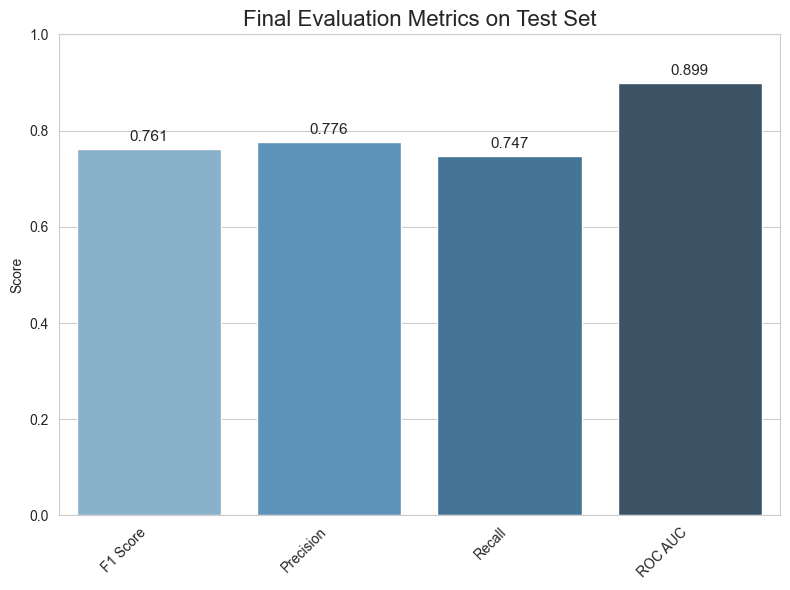

In [27]:
# Convert final_results into a DataFrame for easy plotting
final_results_df = pd.DataFrame(list(final_results.items()), columns=['Metric', 'Value'])

# Set a style for seaborn
sns.set_style("whitegrid")

# Create a figure and axes
plt.figure(figsize=(8, 6))

# Plot the bar chart
sns.barplot(x='Metric', y='Value', data=final_results_df, palette='Blues_d')

# Add labels and title
plt.title("Final Evaluation Metrics on Test Set", fontsize=16)
plt.ylim(0, 1.0)
for index, row in final_results_df.iterrows():
    plt.text(index, row['Value'] + 0.01, f"{row['Value']:.3f}", 
             ha='center', va='bottom', fontsize=11)

plt.xlabel("")
plt.ylabel("Score")
plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()

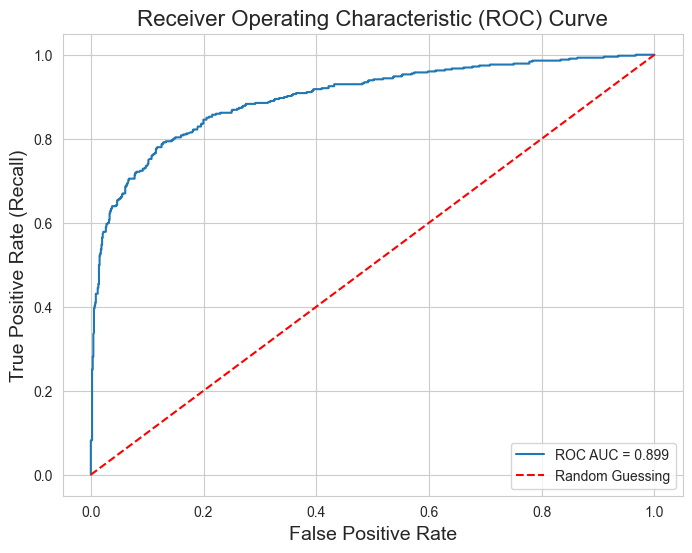

In [28]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_test, y_proba)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC AUC = {final_results['ROC AUC']:.3f}")
plt.plot([0, 1], [0, 1], 'r--', label="Random Guessing")

plt.title("Receiver Operating Characteristic (ROC) Curve", fontsize=16)
plt.xlabel("False Positive Rate", fontsize=14)
plt.ylabel("True Positive Rate (Recall)", fontsize=14)
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

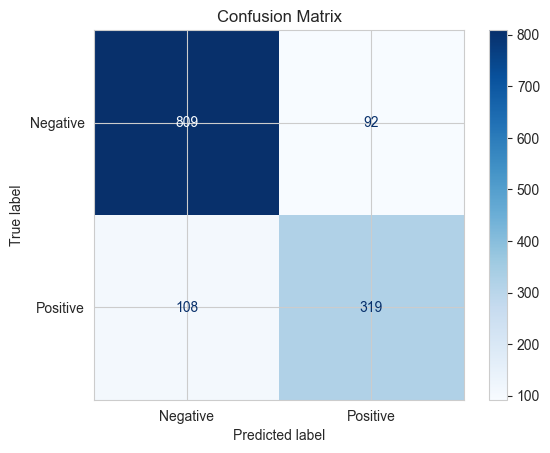

In [29]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Generate predictions
y_pred = best_pipeline.predict(X_test)

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot using the built-in confusion matrix display
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Negative', 'Positive'])
disp.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix")
plt.show()